<a href="https://colab.research.google.com/github/bardiaHSZD/TrendPrediction/blob/main/LSTM_PLSR_Nonlinear_Trend_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Data Acquisition**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gc
gc.enable()
plt.rcParams['figure.figsize'] = [15, 10]
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


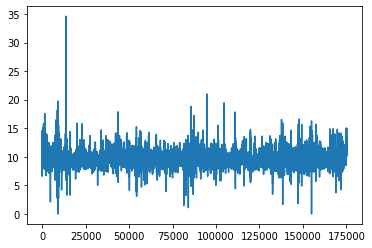

In [ ]:
dataset3 = pd.read_csv('/content/drive/My Drive/Report/ShCo/Train BV split_PLSR.csv', compression = 'infer')
dataset3['PLSR_Predictions'].plot()

In [ ]:
#######################????????????????????
column_names = ['Time','402AI-193.BV, 1VEB8 Cu Boil Reboiler Bv Value,AVG',
                'PLSR_Predictions',
                '402AI-178.NI, 1TKB1 Cu Boil FD  Ni,AVG',
                '402AI-437.AMS, 1TKB1 Cu Boil FD AMSO4,CLC',
                '402AI-439.MR, 1TKB1 Cu Boil MR,CLC',
                '1TKB1 to 1TKB4_AVG|613FIC-802/A_AVG',
                '402AI-176.NH3F, 1TKB1 Cu Boil FD  NH3 Free,AVG',
                'Steam to 1HXB8_AVG|613FIC-9688_AVG',
                'SO2 flow to 1-TK-B5_AVG|613FIC-3629_AVG',
                'H2SO4 to 1TKB8 Flw_AVG|613FIC-0809_AVG',
                'Sulphur to Boil Pots_AVG|613FIC-5125/A_AVG',
                'Liq. SO2 to B5 Temp_AVG|613TI-3633_AVG',
                #'35# LiveStm to 1TKB8_AVG|613FIC-0810_AVG',
                '1TKB5 Level_AVG|613LI-3381_AVG', 'B6 #3 Pot Level_AVG|613LIC-3382_AVG',
                '1TKB7 Lvl_AVG|613LIC-3383_AVG', '1TKB8 Lvl_AVG|613LIC-0808_AVG',
                '1VEB8C Lvl_AVG|613LIC-0866_AVG', '1TKB4 Tmp_AVG|613TI-0813A_AVG',
                '1TKB8 Tmp_AVG|613TI-0813E_AVG', '1TKB7 Temp_AVG|613TI-0813D_AVG',
                '1TKB5 Temp_AVG|613TI-0813B_AVG', '1TKB6 Temp_AVG|613TI-0813C_AVG',
                '1PUB8 Current_AVG|613II-1938_AVG']

dataset3 = dataset3.loc[:,column_names]
T = 15

##**Attention-Based Nonlinear ARX**


In [ ]:
import torch
from torch import nn
from torch.autograd import Variable
from torch import optim
import torch.nn.functional as F
import torch.nn.init as init
import matplotlib
%matplotlib inline
from collections import deque
import datetime as dt, itertools, pandas as pd, matplotlib.pyplot as plt, numpy as np
import logging
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
from sklearn.preprocessing import MinMaxScaler
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARMA

logger = logging.getLogger('TimeSeriesProj')
logger.setLevel(logging.INFO)
use_cuda = torch.cuda.is_available()

In [ ]:
def init_fanin(tensor):
    fanin = tensor.size(1)
    v = 1.0 / np.sqrt(fanin)
    init.uniform_(tensor, -v, v)


def weights_init_(m):
    classname = m.__class__.__name__
    if classname.find("Linear") != -1:
        torch.nn.init.xavier_uniform_(m.weight, gain=1)
        torch.nn.init.constant_(m.bias, 0)

class encoder(nn.Module):
    def __init__(self, input_size, hidden_size, T, logger):
        # input size: number of underlying factors
        # T: number of time steps
        # hidden_size: dimension of the hidden state
        super(encoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.T = T

        self.logger = logger

        
        self.lstm_layer = nn.LSTM(input_size = input_size, hidden_size = hidden_size, num_layers = 1)
        self.attn_linear = nn.Linear(in_features = 2 * hidden_size + T - 1, out_features = 1)
        self.reset_parameters()

    def reset_parameters(self):
        init_fanin(self.attn_linear.weight)
        # init.uniform_(self.l3.weight, -3e-3, 3e-3)

    def forward(self, input_data):
        # input_data: batch_size * T - 1 * input_size
        input_weighted = Variable(input_data.data.new(input_data.size(0), self.T - 1, self.input_size).zero_())
        input_encoded = Variable(input_data.data.new(input_data.size(0), self.T - 1, self.hidden_size).zero_())
        # hidden, cell: initial states with dimention hidden_size
        hidden = self.init_hidden(input_data) # 1 * batch_size * hidden_size
        cell = self.init_hidden(input_data)
        # hidden.requires_grad = False
        # cell.requires_grad = False
        for t in range(self.T - 1):
            # Eqn. 8: concatenate the hidden states with each predictor
            x = torch.cat((hidden.repeat(self.input_size, 1, 1).permute(1, 0, 2),
                           cell.repeat(self.input_size, 1, 1).permute(1, 0, 2),
                           input_data.permute(0, 2, 1)), dim = 2) # batch_size * input_size * (2*hidden_size + T - 1)

            # extra linear num_layers
            x = x.view(-1, self.hidden_size * 2 + self.T - 1)
            # Eqn. 9: Get attention weights
            x = self.attn_linear(x) # (batch_size * input_size) * 1
            attn_weights = F.softmax(x.view(-1, self.input_size)) # batch_size * input_size, attn weights with values sum up to 1.
            # Eqn. 10: LSTM
            weighted_input = torch.mul(attn_weights, input_data[:, t, :]) # batch_size * input_size
            self.lstm_layer.flatten_parameters()
            _, lstm_states = self.lstm_layer(weighted_input.unsqueeze(0), (hidden, cell))
            hidden = lstm_states[0]
            cell = lstm_states[1]
            # Save output
            input_weighted[:, t, :] = weighted_input
            input_encoded[:, t, :] = hidden
        return input_weighted, input_encoded

    def init_hidden(self, x):
        # No matter whether CUDA is used, the returned variable will have the same type as x.
        return Variable(x.data.new(1, x.size(0), self.hidden_size).zero_()) # dimension 0 is the batch dimension

class decoder(nn.Module):
    def __init__(self, encoder_hidden_size, decoder_hidden_size, T, logger, output_size):
        super(decoder, self).__init__()

        self.T = T
        self.encoder_hidden_size = encoder_hidden_size
        self.decoder_hidden_size = decoder_hidden_size

        self.logger = logger

        self.attn_layer = nn.Sequential(nn.Linear(2 * decoder_hidden_size + encoder_hidden_size, encoder_hidden_size),
                                         nn.Tanh(), nn.Linear(encoder_hidden_size, 1))
        self.lstm_layer = nn.LSTM(input_size = output_size, hidden_size = decoder_hidden_size)



        self.fc = nn.Linear(encoder_hidden_size + output_size, output_size)
        self.fc_final = nn.Linear(decoder_hidden_size + encoder_hidden_size, output_size)
        self.reset_parameters()


    def reset_parameters(self):
        init_fanin(self.fc.weight)
        init_fanin(self.fc_final.weight)
        # self.fc.weight.data.normal_()

    def forward(self, input_encoded, y_history):
        # input_encoded: batch_size * T - 1 * encoder_hidden_size
        # y_history: batch_size * (T-1)
        # Initialize hidden and cell, 1 * batch_size * decoder_hidden_size
        hidden = self.init_hidden(input_encoded)
        cell = self.init_hidden(input_encoded)
        # hidden.requires_grad = False
        # cell.requires_grad = False
        for t in range(self.T - 1):
            # Eqn. 12-13: compute attention weights
            ## batch_size * T * (2*decoder_hidden_size + encoder_hidden_size)
            x = torch.cat((hidden.repeat(self.T - 1, 1, 1).permute(1, 0, 2),
                           cell.repeat(self.T - 1, 1, 1).permute(1, 0, 2), input_encoded), dim = 2)
            x = F.softmax(self.attn_layer(x.view(-1, 2 * self.decoder_hidden_size + self.encoder_hidden_size
                                                )).view(-1, self.T - 1)) # batch_size * T - 1, row sum up to 1
            # Eqn. 14: compute context vector
            context = torch.bmm(x.unsqueeze(1), input_encoded)[:, 0, :]# batch_size * encoder_hidden_size
            if t < self.T - 1:
                # Eqn. 15
                temp_output = torch.cat((context, y_history[:, t]), dim = 1)
                y_tilde = self.fc(temp_output) # batch_size * 1

                # Eqn. 16: LSTM
                self.lstm_layer.flatten_parameters()
                _, lstm_output = self.lstm_layer(y_tilde.unsqueeze(0), (hidden, cell))
                hidden = lstm_output[0] # 1 * batch_size * decoder_hidden_size
                cell = lstm_output[1] # 1 * batch_size * decoder_hidden_size

        # Eqn. 22: final output
        y_pred = self.fc_final(torch.cat((hidden[0], context), dim = 1))

        return y_pred

    def init_hidden(self, x):
        return Variable(x.data.new(1, x.size(0), self.decoder_hidden_size).zero_())

In [ ]:
class da_rnn:
    def __init__(self, dataset, logger, input_column_names, encoder_hidden_size = 256, decoder_hidden_size = 256, T = 15,
                 learning_rate = 0.01, batch_size = 60*24*2, parallel = True, debug = False, training_portion = 0.95):
        self.T = T
        
        # Reading the history data
        #dat = pd.read_csv(file_data, nrows = 100 if debug else None)
        dat = dataset.copy()
        
        print("Shape of data: {}.\nMissing in data: {}".format(dat.shape, dat.isnull().sum().sum()))
                
        #self.time_columns = dat.loc[:, [x for x in dat.columns.tolist() if x in ['Date', 'Time']]].values
        #self.time_labels = ['{}-{}'.format(day,hour) for i,(day,hour) in enumerate(self.time_columns)] 
        self.time_labels = dat.loc[:,'Time']        
        # the compressor model input data column names

        self.X = dat.loc[:, [x for x in dat.columns.tolist() if x in input_column_names]].values
        print(self.X.shape)
        # the desired compressor model output data column names:
        output_column_names_desired = {'PLSR_Predictions'}#{'filtered'}#{'402AI-193.BV, 1VEB8 Cu Boil Reboiler Bv Value,AVG'}

        # all of the compressor model output data column names, i.e the extended output list:
        #output_column_names_extended = {'ramped_light_hydrocarbons_LEL', 'ramped_medium_hydrocarbons_LEL', 'ramped_heavy_hydrocarbons_LEL', 'ramped_totalhydrocarbon_LEL'}    
        
        
        self.output_size = len(output_column_names_desired)#len(output_column_names_extended)
        self.y = np.array(dat.loc[:, [x for x in dat.columns.tolist() if x in output_column_names_desired]])#output_column_names_extended]])
        
        self.batch_size = batch_size
        
        self.encoder = encoder(input_size = self.X.shape[1], hidden_size = encoder_hidden_size, T = T,
                              logger = logger).cuda()
        self.decoder = decoder(encoder_hidden_size = encoder_hidden_size,
                               decoder_hidden_size = decoder_hidden_size,
                               T = T, logger = logger, output_size = self.output_size).cuda()

        if parallel:
            self.encoder = nn.DataParallel(self.encoder)
            self.decoder = nn.DataParallel(self.decoder)

        self.encoder_optimizer = optim.Adam(params = self.encoder.parameters(),lr = learning_rate)
        self.decoder_optimizer = optim.Adam(params = self.decoder.parameters(),lr = learning_rate)

        self.train_size = int(self.X.shape[0] * training_portion)
        self.test_size = int((self.X.shape[0] - self.train_size)/10)
        self.valid_size = self.X.shape[0] - self.train_size - self.test_size
        
        print("Training size:", self.train_size)
        print("Testing size:", self.test_size)
        print("Validation size:", self.valid_size)


    def draw_plot(self, ax, x, y, label_str, j):
        # This function is used to plot the desired output discharge pressures 
        major_freq = int(30*24*3600)
        minor_freq = int(1*3600)
        ax.plot(x, y, label= label_str)
        ax.legend(loc = 'upper left')
        ax.set_title('Hydrocarbon % LEL' + str(j+1))
        ax.xaxis.set_major_locator(MultipleLocator(major_freq))
        ax.xaxis.set_minor_locator(MultipleLocator(minor_freq))
        ax.tick_params(labelrotation=45)
        
    def train(self, n_epochs = 10, y_weight=0.001):
      # Confidential


    def train_iteration(self, X, y_history, y_target, y_weight):
      # Confidential


    def predict(self, on_train = False, on_valid = False):
      # Confidential
    
    def forcast(self,input_data):

      # Confidential

    def forcast_new(self, dataset, input_data):
      # Confidential        

In [ ]:
torch.manual_seed(0)
np.random.seed(0) 

input_column_names = {'402AI-178.NI, 1TKB1 Cu Boil FD  Ni,AVG',
                '402AI-437.AMS, 1TKB1 Cu Boil FD AMSO4,CLC',
                '402AI-439.MR, 1TKB1 Cu Boil MR,CLC',
                '1TKB1 to 1TKB4_AVG|613FIC-802/A_AVG',
                '402AI-176.NH3F, 1TKB1 Cu Boil FD  NH3 Free,AVG',
                'Steam to 1HXB8_AVG|613FIC-9688_AVG',
                'SO2 flow to 1-TK-B5_AVG|613FIC-3629_AVG',
                'H2SO4 to 1TKB8 Flw_AVG|613FIC-0809_AVG',
                'Sulphur to Boil Pots_AVG|613FIC-5125/A_AVG',
                'Liq. SO2 to B5 Temp_AVG|613TI-3633_AVG',
                #'35# LiveStm to 1TKB8_AVG|613FIC-0810_AVG',
                '1TKB5 Level_AVG|613LI-3381_AVG', 'B6 #3 Pot Level_AVG|613LIC-3382_AVG',
                '1TKB7 Lvl_AVG|613LIC-3383_AVG', '1TKB8 Lvl_AVG|613LIC-0808_AVG',
                '1VEB8C Lvl_AVG|613LIC-0866_AVG', '1TKB4 Tmp_AVG|613TI-0813A_AVG',
                '1TKB8 Tmp_AVG|613TI-0813E_AVG', '1TKB7 Temp_AVG|613TI-0813D_AVG',
                '1TKB5 Temp_AVG|613TI-0813B_AVG', '1TKB6 Temp_AVG|613TI-0813C_AVG',
                '1PUB8 Current_AVG|613II-1938_AVG'}  

column_names_scaled = {'402AI-178.NI, 1TKB1 Cu Boil FD  Ni,AVG',
                '402AI-437.AMS, 1TKB1 Cu Boil FD AMSO4,CLC',
                '402AI-439.MR, 1TKB1 Cu Boil MR,CLC',
                '1TKB1 to 1TKB4_AVG|613FIC-802/A_AVG',
                '402AI-176.NH3F, 1TKB1 Cu Boil FD  NH3 Free,AVG',
                'Steam to 1HXB8_AVG|613FIC-9688_AVG',
                'SO2 flow to 1-TK-B5_AVG|613FIC-3629_AVG',
                'H2SO4 to 1TKB8 Flw_AVG|613FIC-0809_AVG',
                'Sulphur to Boil Pots_AVG|613FIC-5125/A_AVG',
                'Liq. SO2 to B5 Temp_AVG|613TI-3633_AVG',
                #'35# LiveStm to 1TKB8_AVG|613FIC-0810_AVG',
                '1TKB5 Level_AVG|613LI-3381_AVG', 'B6 #3 Pot Level_AVG|613LIC-3382_AVG',
                '1TKB7 Lvl_AVG|613LIC-3383_AVG', '1TKB8 Lvl_AVG|613LIC-0808_AVG',
                '1VEB8C Lvl_AVG|613LIC-0866_AVG', '1TKB4 Tmp_AVG|613TI-0813A_AVG',
                '1TKB8 Tmp_AVG|613TI-0813E_AVG', '1TKB7 Temp_AVG|613TI-0813D_AVG',
                '1TKB5 Temp_AVG|613TI-0813B_AVG', '1TKB6 Temp_AVG|613TI-0813C_AVG',
                '1PUB8 Current_AVG|613II-1938_AVG'}


plt.rcParams['figure.figsize'] = [5, 5]  

print(dataset_training[column_names_scaled])


from sklearn.preprocessing import StandardScaler
input_scaler = StandardScaler()
scaled_features = input_scaler.fit_transform(dataset_training[input_column_names].values)
dataset_training_scaled = pd.DataFrame(scaled_features, index=dataset_training.index, columns=input_column_names)

dataset_training_scaled['PLSR_Predictions' ] = dataset_training.loc[:,'PLSR_Predictions' ]
dataset_training_scaled['Time' ] = dataset_training.loc[:,'Time' ]


from pickle import dump
dump(input_scaler, open('input_scaler_BV_15_June2021.pkl', 'wb'))
print(dataset_training_scaled)

        1TKB5 Temp_AVG|613TI-0813B_AVG  ...  1PUB8 Current_AVG|613II-1938_AVG
0                             175.7823  ...                          111.2489
1                             176.1195  ...                          108.6216
2                             176.2899  ...                          110.9568
3                             176.4301  ...                          111.0999
4                             176.5682  ...                          109.4026
...                                ...  ...                               ...
167113                        215.3902  ...                          126.0804
167114                        215.3902  ...                          125.4633
167115                        215.3902  ...                          125.8959
167116                        215.3232  ...                          125.6797
167117                        215.3172  ...                          124.7678

[167118 rows x 21 columns]
        1TKB5 Temp_AVG|613TI-0813B_A

Shape of data: (167118, 23).
Missing in data: 0
(167118, 21)
Training size: 133694
Testing size: 3342
Validation size: 30082
DataParallel(
  (module): encoder(
    (lstm_layer): LSTM(21, 256)
    (attn_linear): Linear(in_features=526, out_features=1, bias=True)
  )
)
DataParallel(
  (module): decoder(
    (attn_layer): Sequential(
      (0): Linear(in_features=768, out_features=256, bias=True)
      (1): Tanh()
      (2): Linear(in_features=256, out_features=1, bias=True)
    )
    (lstm_layer): LSTM(1, 256)
    (fc): Linear(in_features=257, out_features=1, bias=True)
    (fc_final): Linear(in_features=512, out_features=1, bias=True)
  )
)
Iterations per epoch: 46.421527777777776 ~ 47.
progress:  2.154398563734291
progress:  9.573831527159099
[9.42001438 0.09421439 0.09421311 0.09421948 0.09422647 0.09422798
 0.09420505 0.09418414 0.09418006 0.0941678  0.09418108 0.09420042
 0.09420285 0.09421647 0.0942377  9.42462635 0.09424492 0.09423294
 0.09423965 0.09424829 0.09426721 0.09428168 0

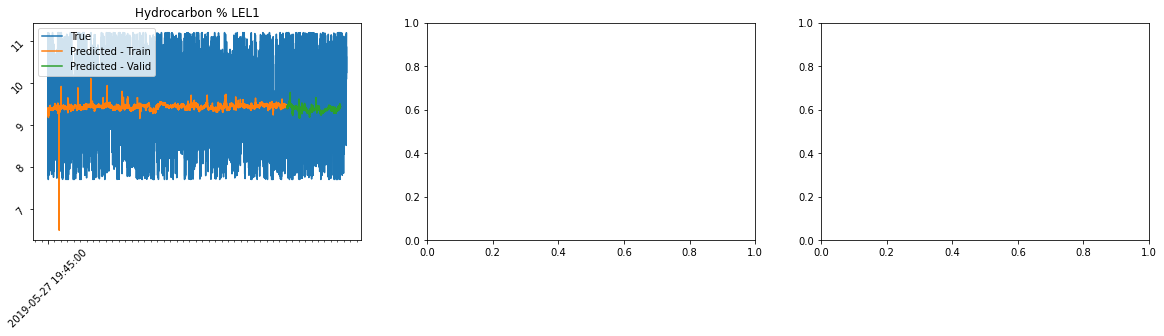

progress:  2.154398563734291
progress:  9.573831527159099
[9.52049541 0.09519747 0.09518988 0.09518097 0.0951978  0.09523305
 0.09525826 0.0952967  0.095338   0.09540874 0.09558102 0.09568246
 0.09542905 0.09540758 0.09552964 9.56016731 0.09569163 0.09560752
 0.09565289 0.095677   0.09575299 0.09579135 0.09570987 0.0958103
 0.09639364 0.09666509 0.09615613 0.09602347 0.09593036 0.09592761
 9.5916605  0.0958664  0.09589322 0.09594787 0.09592153 0.09585878
 0.09585617 0.0958442  0.09586787 0.0958847  0.09576992 0.0957048
 0.09571872 0.09572413 0.09569968]
Epoch 5, Training Loss: 0.026972674071154695, Validation Loss: 0.03093128092586994.
progress:  86.17594254937164


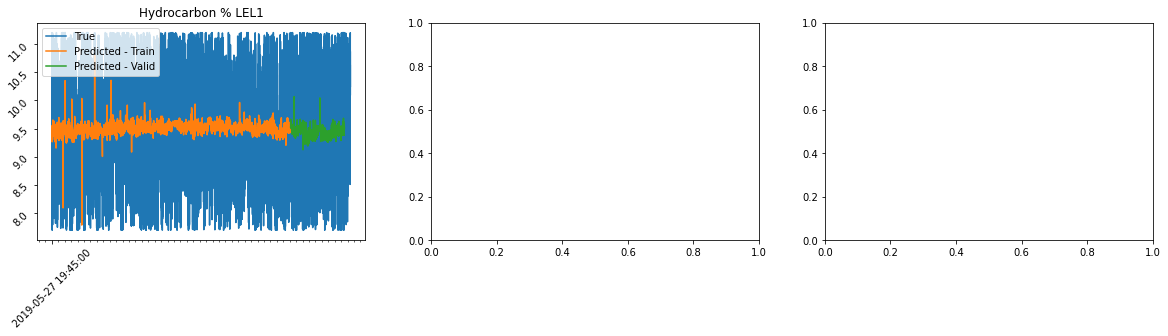

progress:  2.154398563734291
progress:  9.573831527159099
[9.49172592 0.0949111  0.09490753 0.09486944 0.09490942 0.09500895
 0.09513831 0.09532269 0.09547313 0.09573332 0.09630438 0.0966007
 0.09565488 0.09554776 0.09586038 9.60332394 0.09623751 0.09595741
 0.09608576 0.09615773 0.09637445 0.09650185 0.09625356 0.09648017
 0.09787379 0.09843423 0.09727175 0.0969457  0.09674072 0.09674574
 9.6735878  0.09656768 0.09661862 0.09674416 0.09669294 0.09654988
 0.09652191 0.09649132 0.09653492 0.09654958 0.09626889 0.09612556
 0.09617704 0.09619562 0.0962067 ]
Epoch 10, Training Loss: 0.02407054270201541, Validation Loss: 0.031128128990530968.
progress:  86.17594254937164


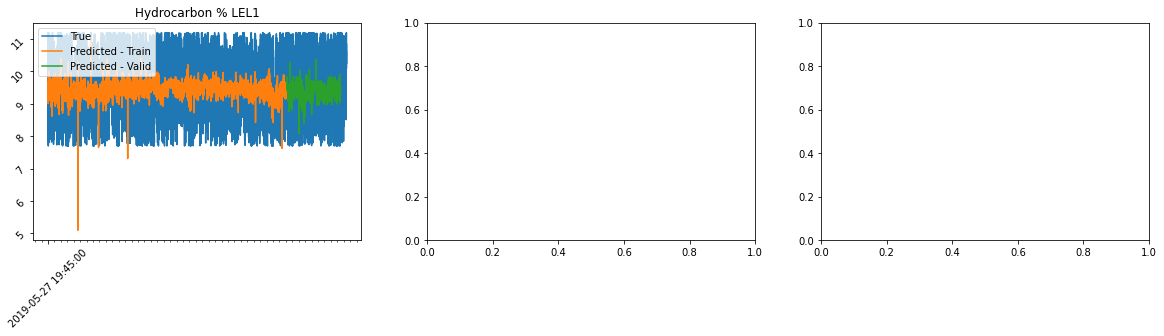

progress:  2.154398563734291
progress:  9.573831527159099
[ 9.69368172  0.09692607  0.09695901  0.09691937  0.09712987  0.09749914
  0.09795795  0.09853261  0.09892861  0.09958649  0.10091434  0.10140327
  0.09890697  0.09869067  0.09927225  9.95622635  0.09989596  0.09911178
  0.09929882  0.09935657  0.09971002  0.10003894  0.09981795  0.10018253
  0.10215117  0.10272156  0.10112928  0.1006299   0.10037496  0.10042898
 10.04769802  0.10013712  0.10022619  0.1004529   0.1004316   0.10029013
  0.10018142  0.10004852  0.10010067  0.10004219  0.09963915  0.09952289
  0.09972418  0.0997916   0.09998454]
Epoch 15, Training Loss: 0.0204406026750803, Validation Loss: 0.031203219667077065.
progress:  86.17594254937164


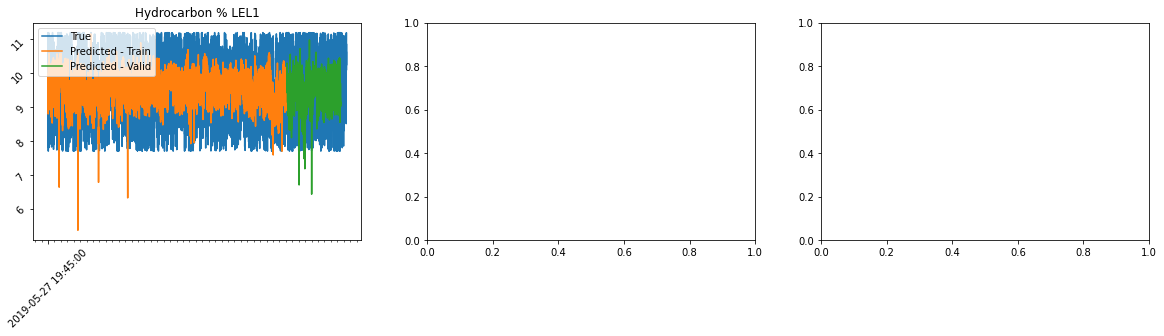

progress:  2.154398563734291
progress:  9.573831527159099
[9.53831005 0.09549962 0.09569495 0.0958007  0.09620908 0.09684826
 0.09759854 0.09841775 0.09888628 0.09973653 0.10120371 0.10156091
 0.09832442 0.09805451 0.09865388 9.89359283 0.09930706 0.09823125
 0.09844207 0.09846087 0.09887364 0.09929076 0.09915691 0.09951304
 0.10112036 0.10128296 0.09993199 0.09947279 0.09933241 0.09942929
 9.95549774 0.09912957 0.09917035 0.09938945 0.09943722 0.09934923
 0.09910209 0.09888478 0.09890122 0.09877066 0.09848944 0.09857768
 0.098894   0.09899374 0.09937706]
Epoch 20, Training Loss: 0.01871765684336424, Validation Loss: 0.04428333789110184.
progress:  86.17594254937164


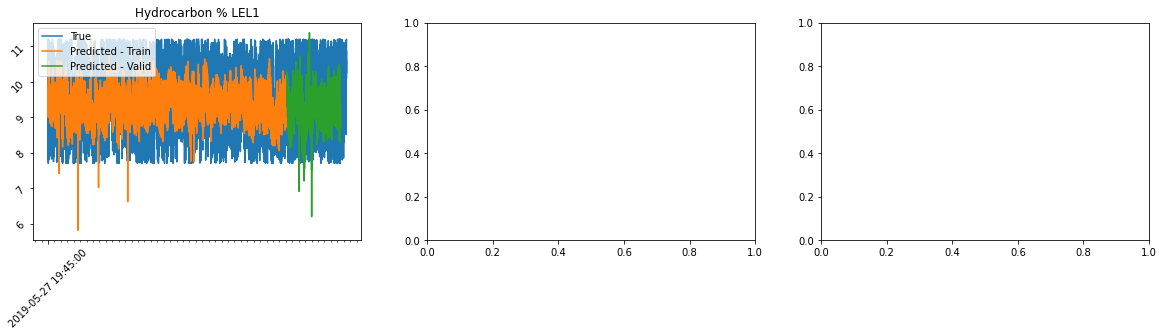

progress:  2.154398563734291
progress:  9.573831527159099
[ 9.94560623  0.09956313  0.09972977  0.09980555  0.10011576  0.10063152
  0.10124351  0.10196274  0.10238745  0.10311412  0.10425081  0.10453534
  0.10188467  0.1016632   0.10213674 10.23783875  0.10277557  0.10185949
  0.10199229  0.10197497  0.10225053  0.10262457  0.10260563  0.10289894
  0.10399039  0.10405944  0.10302974  0.10268641  0.1026025   0.10268517
 10.28294086  0.10246819  0.1024395   0.10258058  0.10265104  0.10259279
  0.10232977  0.1021662   0.10215217  0.10206792  0.10191978  0.10204451
  0.10229459  0.10234984  0.10269814]
Epoch 25, Training Loss: 0.018327633671938105, Validation Loss: 0.036456335335969925.
progress:  86.17594254937164


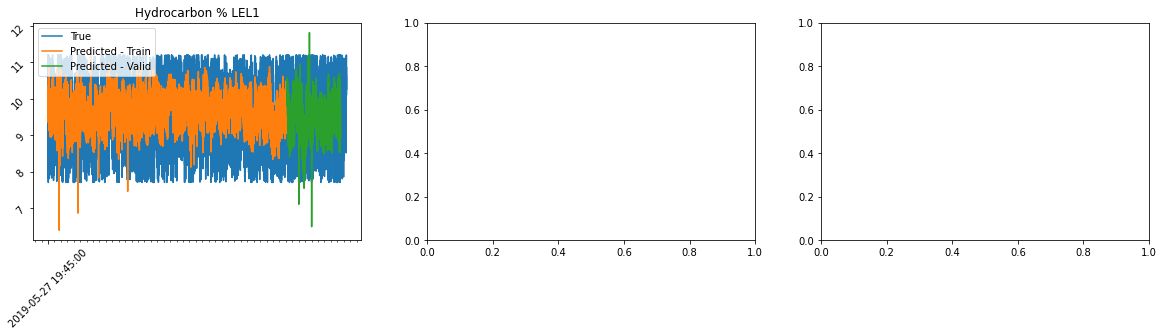

progress:  2.154398563734291
progress:  9.573831527159099
[ 9.61480618  0.09639246  0.09673971  0.097033    0.097515    0.09818222
  0.09891121  0.09974129  0.10011874  0.10080444  0.10184701  0.10196554
  0.09923323  0.09901842  0.09948346  9.97400188  0.10012811  0.0992104
  0.09940096  0.09945069  0.09980976  0.10034091  0.10033464  0.10060575
  0.10159645  0.1014522   0.10040291  0.10007003  0.10002644  0.10013473
 10.03100586  0.09992705  0.09988779  0.10000505  0.10004506  0.09995811
  0.09963706  0.0994962   0.09948763  0.09942677  0.09934541  0.09949971
  0.09972002  0.09974642  0.10006955]
Epoch 30, Training Loss: 0.018902044604591866, Validation Loss: 0.05327678099274635.
progress:  86.17594254937164


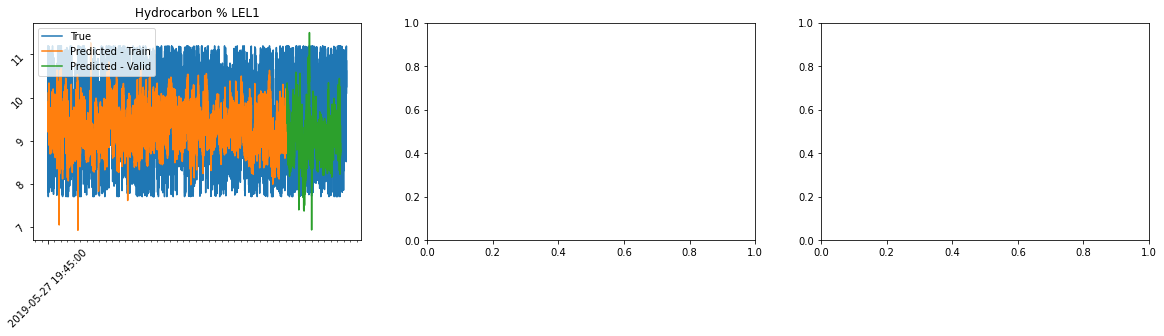

progress:  2.154398563734291
progress:  9.573831527159099
[ 9.81711674  0.0984854   0.09889502  0.09928349  0.09984541  0.10054914
  0.10125845  0.10208293  0.10237573  0.10296482  0.10381587  0.10388208
  0.10137756  0.10114799  0.10153513 10.16955566  0.10208659  0.10128037
  0.10149524  0.10160781  0.10198093  0.10253767  0.10253723  0.10273606
  0.10345032  0.1032573   0.10233137  0.10205107  0.10202361  0.10210943
 10.22736835  0.10187353  0.10179554  0.10189756  0.10194337  0.1018829
  0.10158298  0.10148864  0.10148692  0.10148308  0.1014517   0.10160542
  0.10176285  0.10173815  0.10202445]
Epoch 35, Training Loss: 0.017225866344697933, Validation Loss: 0.04553167521953583.
progress:  86.17594254937164


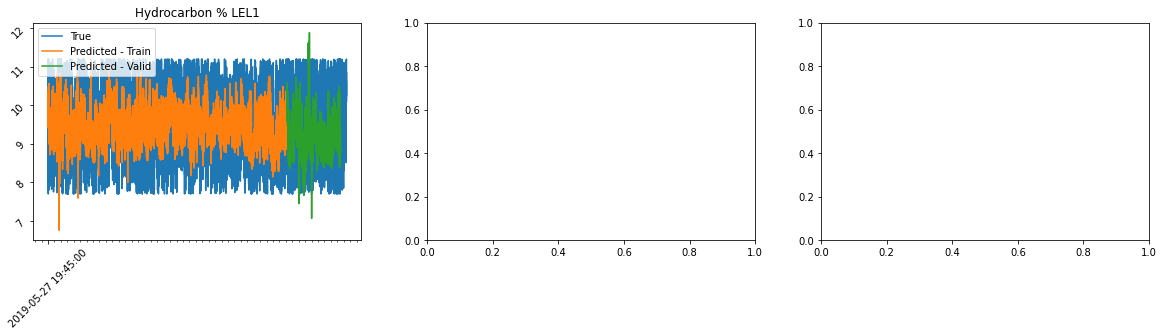

progress:  2.154398563734291
progress:  9.573831527159099
[ 9.81058407  0.09849236  0.09897779  0.09948041  0.10012002  0.10084805
  0.10150326  0.1022302   0.1023575   0.1027826   0.10338027  0.10339944
  0.10125118  0.10109508  0.10143163 10.15369415  0.10188456  0.10125884
  0.10148249  0.10165525  0.10204122  0.10259041  0.10259103  0.10276643
  0.10327836  0.1030698   0.1022049   0.10195456  0.10194601  0.10202527
 10.2162571   0.10181631  0.10175926  0.10181689  0.10181554  0.10173818
  0.10145057  0.1014058   0.10140733  0.10143065  0.10144303  0.10156526
  0.10165762  0.10160084  0.10180361]
Epoch 40, Training Loss: 0.017355564248530155, Validation Loss: 0.046271178871393204.
progress:  86.17594254937164


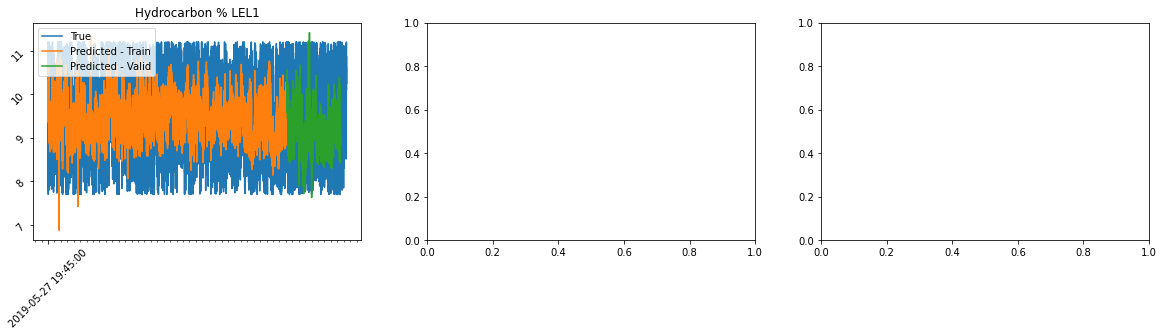

progress:  2.154398563734291
progress:  9.573831527159099
[ 9.95609379  0.09998998  0.10051964  0.10108319  0.10178072  0.10254924
  0.10319924  0.10391138  0.10401603  0.10442057  0.10494893  0.10494246
  0.10282743  0.10269605  0.10301342 10.30860233  0.10345689  0.10283516
  0.10305567  0.10322138  0.10356958  0.10406264  0.10413562  0.10434023
  0.10475806  0.10453179  0.10370718  0.10347201  0.10347763  0.10354878
 10.36910534  0.10335709  0.10330476  0.10334075  0.10333842  0.1032623
  0.10296992  0.10298001  0.10298749  0.10303276  0.10308989  0.10322262
  0.1033145   0.10324911  0.10343608]
Epoch 45, Training Loss: 0.016898790651813468, Validation Loss: 0.046927452087402344.
progress:  86.17594254937164


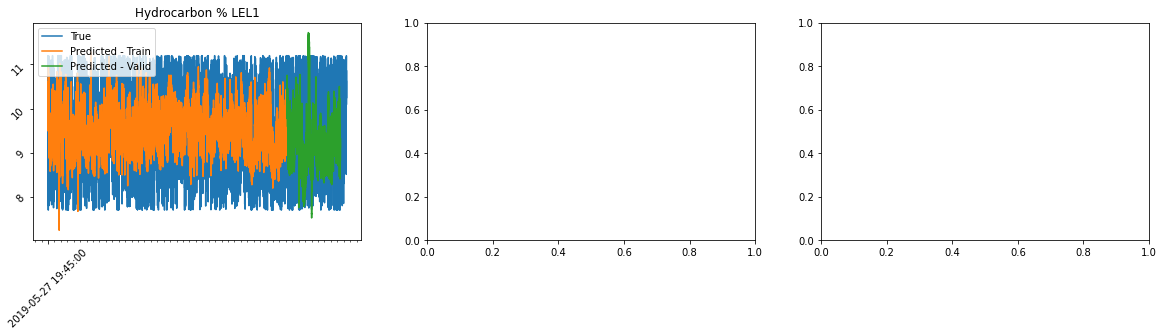

progress:  2.154398563734291
progress:  9.573831527159099
[ 9.98499107  0.10034445  0.1009559   0.10159217  0.10233001  0.10310969
  0.10373118  0.10438058  0.10447533  0.10487795  0.10536239  0.10540603
  0.10317287  0.103072    0.10335088 10.3469696   0.10384849  0.10326695
  0.10349546  0.10369667  0.10404077  0.10452015  0.104645    0.10492314
  0.1053728   0.10521213  0.10422572  0.10396568  0.10396574  0.10404219
 10.41796207  0.10386069  0.10380723  0.10382083  0.10382759  0.10372468
  0.10344469  0.10351343  0.10352226  0.10358345  0.10362971  0.10374269
  0.10382232  0.10373977  0.10389565]
Epoch 50, Training Loss: 0.016287634664393487, Validation Loss: 0.04580593481659889.
progress:  86.17594254937164


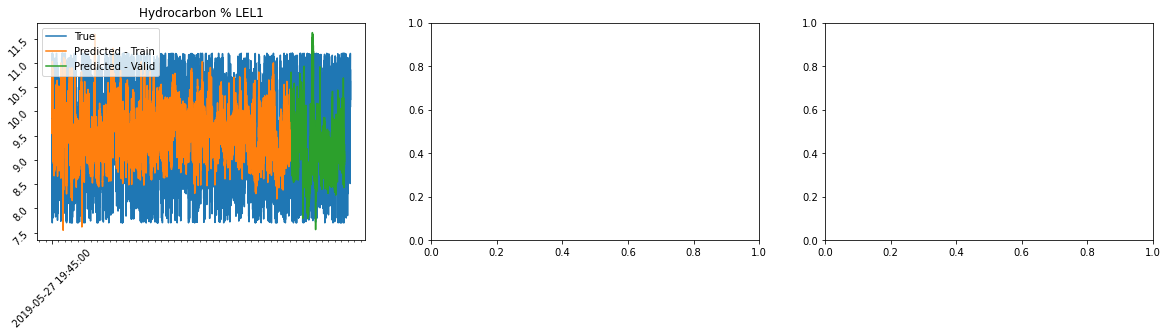

progress:  2.154398563734291
progress:  9.573831527159099
[ 9.89732742  0.09960682  0.10035833  0.10110159  0.10187633  0.10259361
  0.10306458  0.10356443  0.10351401  0.10378993  0.10411091  0.10419023
  0.10236462  0.10230927  0.10248548 10.26415443  0.10310075  0.102649
  0.10295475  0.10326092  0.10362418  0.10414936  0.10422955  0.10452575
  0.10500449  0.10496035  0.10379378  0.10352226  0.10348922  0.10354468
 10.36768723  0.10337939  0.10330078  0.10328     0.10328911  0.10318686
  0.1029386   0.10305702  0.10308067  0.10316921  0.10315295  0.10317077
  0.10315812  0.10298972  0.10298235]
Epoch 55, Training Loss: 0.016864702660352626, Validation Loss: 0.046113528311252594.
progress:  86.17594254937164


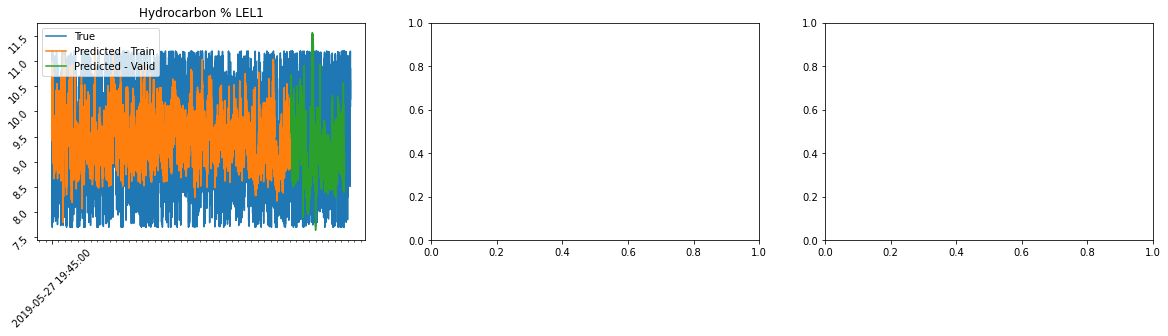

progress:  2.154398563734291
progress:  9.573831527159099
[ 9.95566559  0.10022714  0.10100719  0.10174963  0.1024931   0.10318614
  0.1036733   0.10422198  0.10428138  0.10465972  0.10505     0.10523477
  0.10308208  0.10304691  0.10325355 10.34861279  0.10396504  0.10348118
  0.10372991  0.10397872  0.10427619  0.10476624  0.10488652  0.10518079
  0.10550717  0.10537238  0.10435366  0.10410265  0.10410626  0.1041862
 10.43381405  0.10402067  0.10392916  0.10387932  0.10390814  0.10380003
  0.10352098  0.10365769  0.10364903  0.10374105  0.10378571  0.10386325
  0.10388007  0.10370545  0.1037778 ]
Epoch 60, Training Loss: 0.016547946299010134, Validation Loss: 0.04828799515962601.
progress:  86.17594254937164


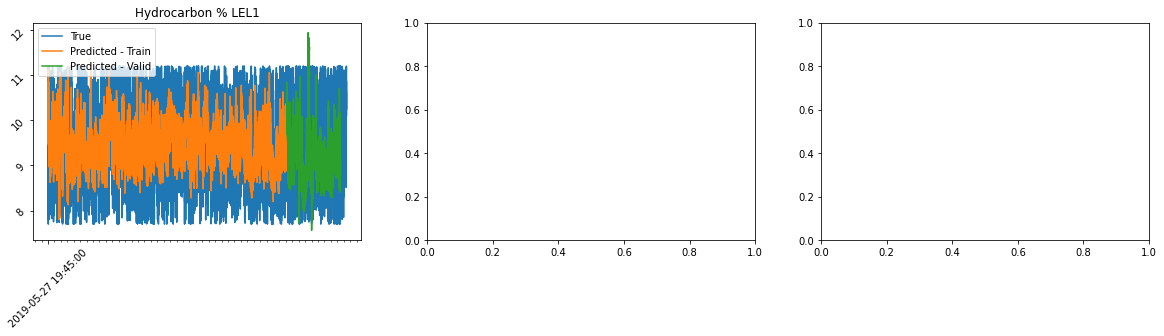

progress:  2.154398563734291
progress:  9.573831527159099
[ 9.96274757  0.10043645  0.10134677  0.10219817  0.10293253  0.10348685
  0.10374142  0.10403399  0.10392667  0.10409524  0.10433744  0.1046138
  0.10309949  0.10313948  0.10334297 10.36194134  0.10416552  0.10381802
  0.10405483  0.10428709  0.10459679  0.10521603  0.10536529  0.10569206
  0.10608967  0.10601846  0.10482115  0.1045091   0.10449549  0.10458662
 10.47373581  0.10441498  0.10431209  0.10423633  0.10422971  0.10411805
  0.10386909  0.10401709  0.10400847  0.10412647  0.10415181  0.10413259
  0.1040345   0.10375265  0.10364515]
Epoch 65, Training Loss: 0.01605313031518079, Validation Loss: 0.047648362815380096.
progress:  86.17594254937164


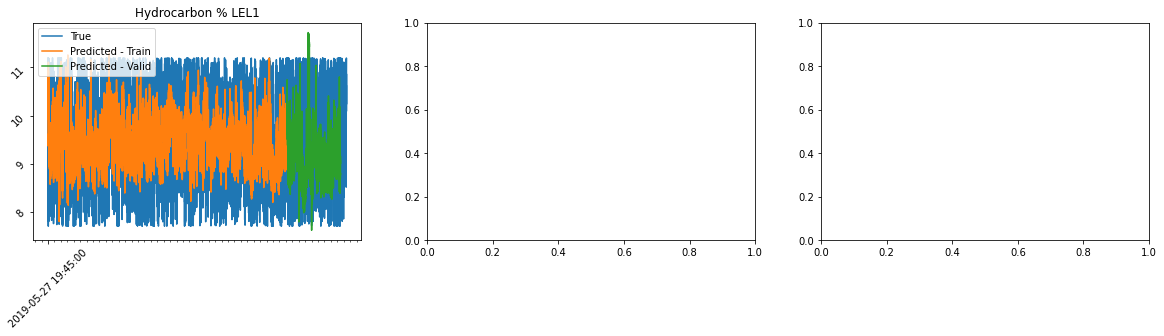

progress:  2.154398563734291
progress:  9.573831527159099
[10.14160252  0.10226332  0.10321828  0.10409714  0.10481453  0.10531005
  0.10551212  0.10575048  0.10569765  0.10592202  0.10622878  0.10656772
  0.10494129  0.10496198  0.10519528 10.55331898  0.10611719  0.10582376
  0.10611989  0.10638118  0.1066942   0.10718666  0.10729799  0.10748064
  0.10766958  0.10742517  0.10653678  0.1062728   0.10630177  0.10639606
 10.65543938  0.10624767  0.106158    0.10608072  0.1060881   0.10594714
  0.10564665  0.10578426  0.1057452   0.10581491  0.10585363  0.10586698
  0.10579968  0.10552895  0.10550195]
Epoch 70, Training Loss: 0.015422951331005451, Validation Loss: 0.04364696517586708.
progress:  86.17594254937164


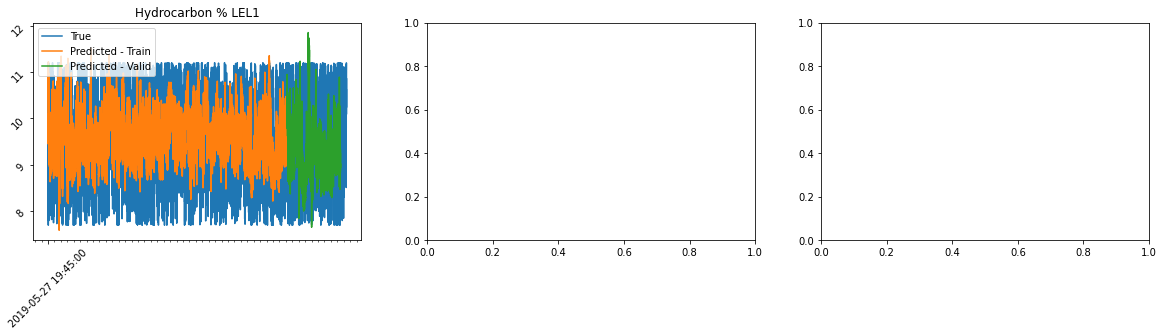

progress:  2.154398563734291
progress:  9.573831527159099
[10.15680313  0.10249717  0.10344284  0.10428342  0.10479872  0.10503659
  0.10503457  0.10507711  0.10494879  0.10501987  0.10512626  0.10533512
  0.10453267  0.10472597  0.10494772 10.54187012  0.10605905  0.1061188
  0.10643056  0.10671524  0.10700332  0.10744341  0.10757941  0.10779351
  0.10800888  0.10782609  0.10691224  0.1066153   0.1066003   0.10666784
 10.67533112  0.10650976  0.10644629  0.1063665   0.10636349  0.10623244
  0.10598517  0.10610409  0.10602794  0.106022    0.10594059  0.10577484
  0.10557443  0.10518441  0.10490283]
Epoch 75, Training Loss: 0.016308385680647606, Validation Loss: 0.03834841400384903.
progress:  86.17594254937164


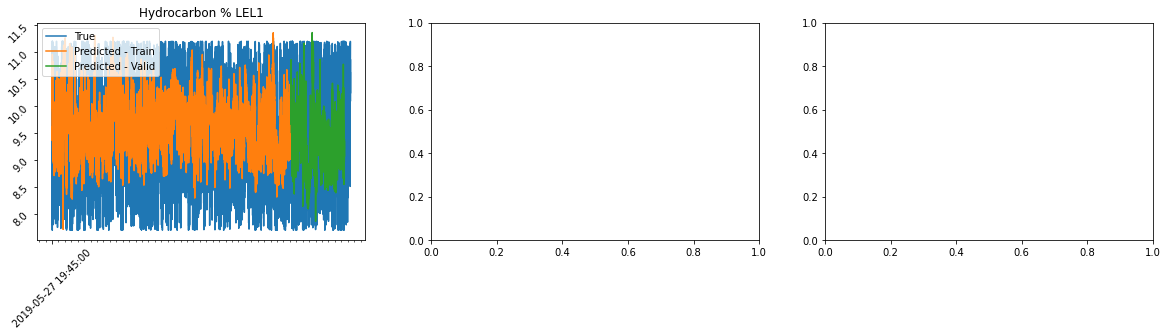

progress:  86.17594254937164


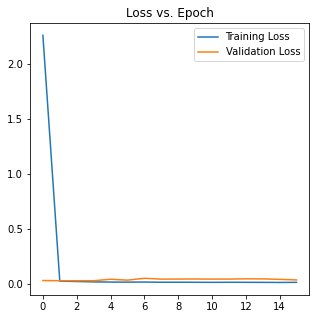

In [ ]:
model = da_rnn(dataset= dataset_training_scaled, logger = logger, input_column_names = input_column_names, parallel = True, learning_rate = .0005, training_portion=0.8)

print(model.encoder)
print(model.decoder)
train_loss, validation_loss = model.train(n_epochs = 80, y_weight= 0.01)

y_pred = model.predict()


plt.figure()
plt.plot(range(len(model.train_losses)), model.train_losses)
plt.plot(range(len(model.validation_losses)), model.validation_losses)
plt.legend(['Training Loss', 'Validation Loss'], loc = 'upper right')
plt.title('Loss vs. Epoch')
plt.show()

In [ ]:
dataset_training_scaled['filtered'] = filtered
dataset4 = dataset_training_scaled.copy()#dataset3.copy()
dataset4 = dataset4.fillna(method='ffill')
dataset_sensitivity_forward=dataset4.loc[0:len(dataset4),:].copy()
input_data = dataset_sensitivity_forward.loc[:, [x for x in dataset_sensitivity_forward.columns.tolist() if x in input_column_names]].values
print(input_data.shape)
print(dataset_training)

(167118, 21)
        Unnamed: 0  ... 1PUB8 Current_AVG|613II-1938_AVG
0                0  ...                         111.2489
1                2  ...                         108.6216
2                3  ...                         110.9568
3                4  ...                         111.0999
4                5  ...                         109.4026
...            ...  ...                              ...
167113      175058  ...                         126.0804
167114      175059  ...                         125.4633
167115      175060  ...                         125.8959
167116      175061  ...                         125.6797
167117      175062  ...                         124.7678

[167118 rows x 25 columns]


In [ ]:
model.encoder.eval()
model.decoder.eval()

DataParallel(
  (module): decoder(
    (attn_layer): Sequential(
      (0): Linear(in_features=768, out_features=256, bias=True)
      (1): Tanh()
      (2): Linear(in_features=256, out_features=1, bias=True)
    )
    (lstm_layer): LSTM(1, 256)
    (fc): Linear(in_features=257, out_features=1, bias=True)
    (fc_final): Linear(in_features=512, out_features=1, bias=True)
  )
)

In [ ]:
y_forcats_before = model.forcast_new(input_data=input_data, dataset=dataset_training_scaled)#dataset_training)


progress:  1.7233332136574158


In [ ]:
torch.save(model.encoder.state_dict(), '/content/drive/My Drive/Report/ShCo/Dynamic Models/BV_encoder_unfiltered_truncated_2days_T15_june2021.pth')
torch.save(model.decoder.state_dict(), '/content/drive/My Drive/Report/ShCo/Dynamic Models/BV_decoder_unfiltered_truncated_2days_T15_june2021.pth')

In [ ]:
dataset_sensitivity_forward=dataset4.loc[15:len(dataset4),:].copy()
dataset_sensitivity_history=dataset4.loc[0:15,:].copy()
input_column_names = {'402AI-178.NI, 1TKB1 Cu Boil FD  Ni,AVG',
                '402AI-437.AMS, 1TKB1 Cu Boil FD AMSO4,CLC',
                '402AI-439.MR, 1TKB1 Cu Boil MR,CLC',
                '1TKB1 to 1TKB4_AVG|613FIC-802/A_AVG',
                '402AI-176.NH3F, 1TKB1 Cu Boil FD  NH3 Free,AVG',
                'Steam to 1HXB8_AVG|613FIC-9688_AVG',
                'SO2 flow to 1-TK-B5_AVG|613FIC-3629_AVG',
                'H2SO4 to 1TKB8 Flw_AVG|613FIC-0809_AVG',
                'Sulphur to Boil Pots_AVG|613FIC-5125/A_AVG',
                'Liq. SO2 to B5 Temp_AVG|613TI-3633_AVG',
                #'35# LiveStm to 1TKB8_AVG|613FIC-0810_AVG',
                '1TKB5 Level_AVG|613LI-3381_AVG', 'B6 #3 Pot Level_AVG|613LIC-3382_AVG',
                '1TKB7 Lvl_AVG|613LIC-3383_AVG', '1TKB8 Lvl_AVG|613LIC-0808_AVG',
                '1VEB8C Lvl_AVG|613LIC-0866_AVG', '1TKB4 Tmp_AVG|613TI-0813A_AVG',
                '1TKB8 Tmp_AVG|613TI-0813E_AVG', '1TKB7 Temp_AVG|613TI-0813D_AVG',
                '1TKB5 Temp_AVG|613TI-0813B_AVG', '1TKB6 Temp_AVG|613TI-0813C_AVG',
                '1PUB8 Current_AVG|613II-1938_AVG'}

input_data = dataset_sensitivity_forward.loc[:, [x for x in dataset_sensitivity_forward.columns.tolist() if x in input_column_names]]


In [ ]:
model_RNN_loaded_sensitivity = da_rnn(dataset = dataset_sensitivity_history, logger = logger, input_column_names = input_column_names, parallel = True)



model_RNN_loaded_sensitivity.encoder.load_state_dict(torch.load('/content/drive/My Drive/Report/ShCo/Dynamic Models/BV_encoder_unfiltered_truncated_2days_T15_june2021.pth'))
model_RNN_loaded_sensitivity.decoder.load_state_dict(torch.load('/content/drive/My Drive/Report/ShCo/Dynamic Models/BV_decoder_unfiltered_truncated_2days_T15_june2021.pth'))

model_RNN_loaded_sensitivity.encoder.eval()
model_RNN_loaded_sensitivity.decoder.eval()


Shape of data: (16, 24).
Missing in data: 0
(16, 21)
Training size: 15
Testing size: 0
Validation size: 1


DataParallel(
  (module): decoder(
    (attn_layer): Sequential(
      (0): Linear(in_features=768, out_features=256, bias=True)
      (1): Tanh()
      (2): Linear(in_features=256, out_features=1, bias=True)
    )
    (lstm_layer): LSTM(1, 256)
    (fc): Linear(in_features=257, out_features=1, bias=True)
    (fc_final): Linear(in_features=512, out_features=1, bias=True)
  )
)

In [ ]:
y_forcast = [] 
y_forcast = model_RNN_loaded_sensitivity.forcast_new(input_data=input_data, dataset=dataset_sensitivity_history)

progress:  1.723487908655141


In [ ]:
device = torch.device('cpu')
model_RNN_loaded_sensitivity.encoder.to(device)
model_RNN_loaded_sensitivity.decoder.to(device)
torch.save(model_RNN_loaded_sensitivity.encoder.state_dict(), '/content/drive/My Drive/Report/ShCo/Dynamic Models/BV_encoder_unfiltered_truncated_2days_T15_cpu_june2021.pth')
torch.save(model_RNN_loaded_sensitivity.decoder.state_dict(), '/content/drive/My Drive/Report/ShCo/Dynamic Models/BV_decoder_unfiltered_truncated_2days_T15_cpu_june2021.pth')

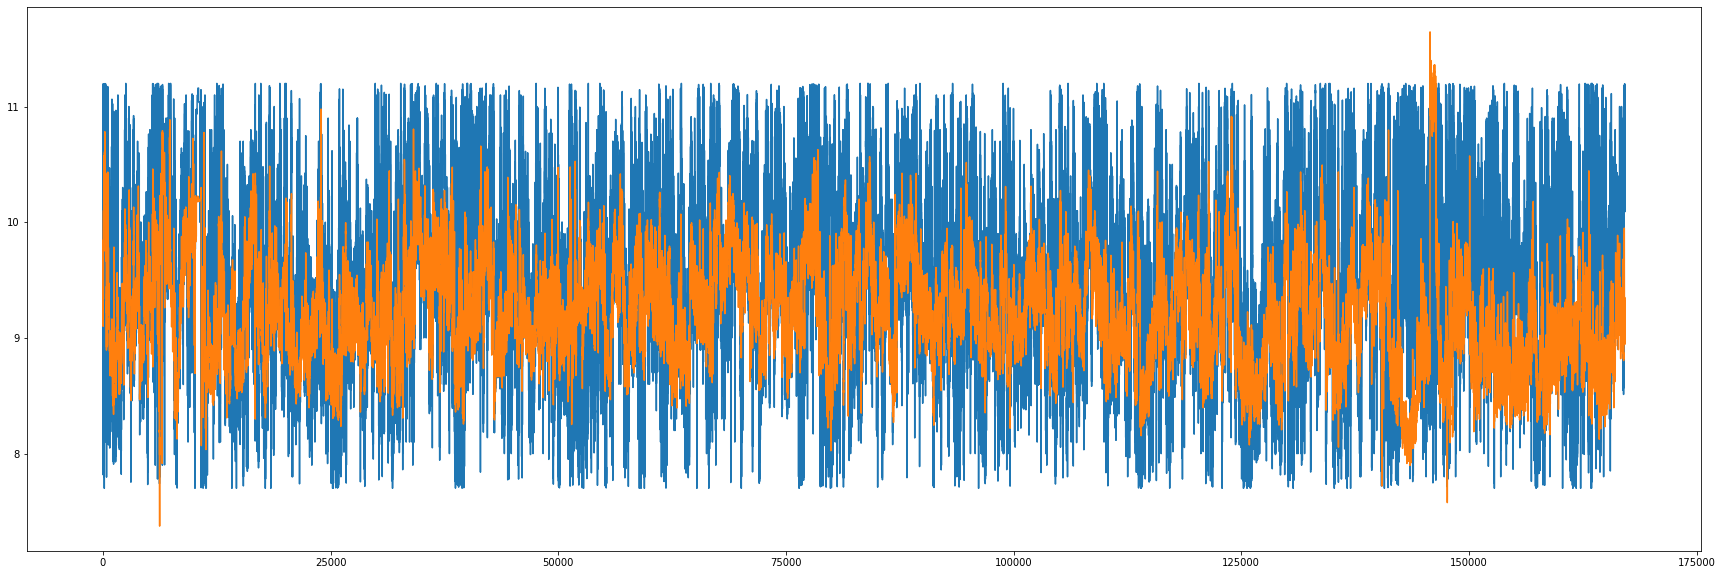

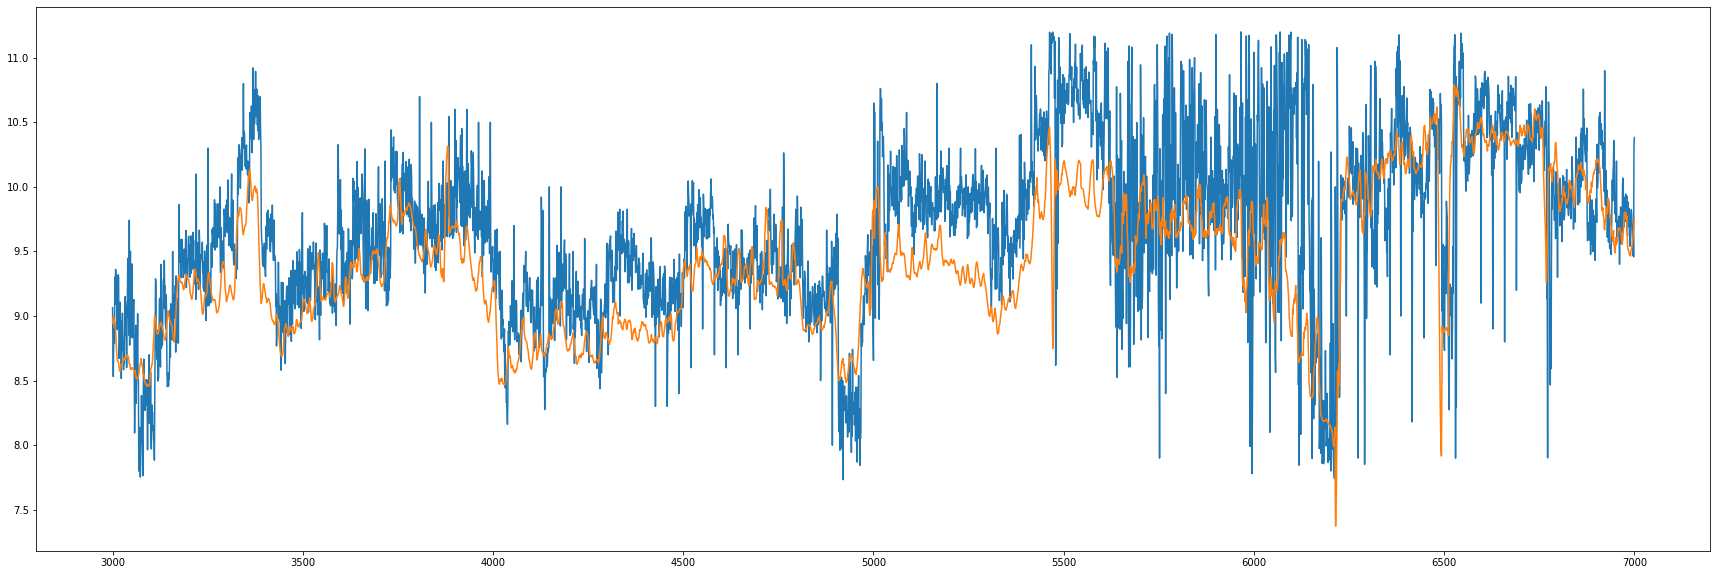

"\nplt.show()\nplt.plot(np.linspace(267840-50000, 267840, 50000), y_forcats_before[:,3]) \nplt.plot(dataset4.loc[267840-50000:267840,'ramped_totalhydrocarbon_LEL']) \n"

In [ ]:
plt.rcParams['figure.figsize'] = [30, 10]  
plt.plot(dataset4.loc[15:len(dataset4),'PLSR_Predictions']) 
plt.plot(np.linspace(15, len(dataset4), len(dataset4)-15), y_forcast[:,0]) 

plt.show()

start = 3000
end = 7000
plt.plot(dataset4.loc[start:end,'PLSR_Predictions']) 
plt.plot(np.linspace(start, end, end-start), y_forcast[start:end,0]) 
plt.show() 

****************************************************************
****************************************************************


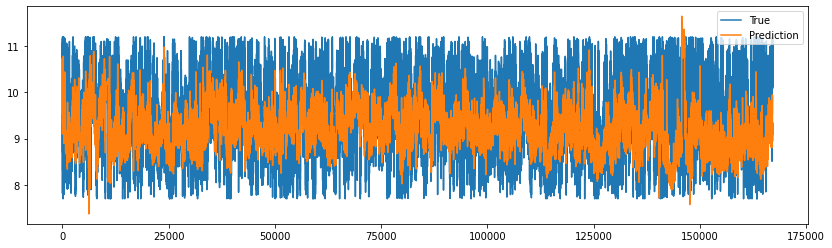

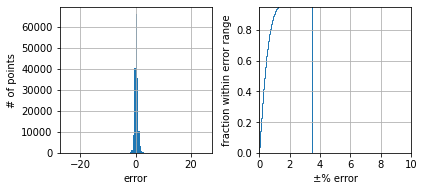

----------------------------------------------------------------
Density Plot
----------------------------------------------------------------


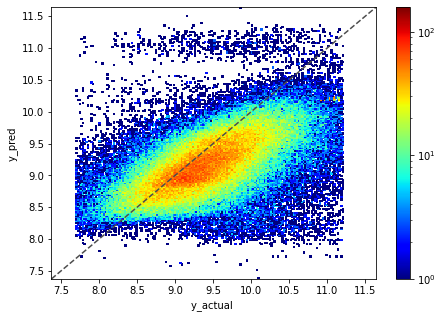

In [ ]:
final_targets=['PLSR_Predictions']

true_data = dataset_training_scaled.loc[15:len(dataset4),'PLSR_Predictions']

test_data = y_forcast[:,0]

print('*'*64)
print('*'*64)
plt.figure(figsize=(14, 4))
plt.plot(true_data)
plt.plot(np.linspace(15, len(dataset4), len(dataset4)-15),test_data)
plt.legend(['True','Prediction'])
plt.show()

  
error = (true_data- test_data)
fig = plt.figure(figsize=(6,3))
ax1 = fig.add_subplot(1,2,1)
ax1.hist(error.values, bins = 100, range=(-25, 25)) 
ax1.set_xlabel('error')
ax1.set_ylabel("# of points")
ax1.grid(True)
ax2 = fig.add_subplot(1,2,2)
ax2.hist(np.abs(error), bins = 300, cumulative=True, density = True, histtype = 'step');
ax2.set_xlim(xmin=0, xmax=10)
ax2.set_ylim(ymin=0, ymax=0.95)
ax2.set_xlabel("±% error")
ax2.set_ylabel("fraction within error range")
ax2.grid(True)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


print('-'*64)
print('Density Plot')
print('-'*64)
import matplotlib as mpl
y = true_data.values
y=y.reshape((len(y),)) 
ypred = test_data
ypred=ypred.reshape((len(ypred),)) 
fig = plt.figure(figsize=(16, 5))
ax1 = fig.add_subplot(1,2,1)
h=ax1.hist2d(x = y, y = ypred, bins=200, cmin=1, norm=mpl.colors.LogNorm(), cmap='jet',range=[[test_data.min(), test_data.max()], [test_data.min(), test_data.max()]])
diag_line, = ax1.plot(ax1.get_xlim(), ax1.get_ylim(), ls="--", c=".3")
fig.colorbar(h[3], ax=ax1)
ax1.set_xlabel('y_actual ')
ax1.set_ylabel('y_pred ')
plt.show()